# This workbook will describe the process of predict depth at a Combined Sewer Overflow based on catchment rainfall data. An additional feature (time of day) will be used to test if the model is sensitive enough to predict a diurnal profile based on this real usecase in a small catchment 


In [49]:
#import libaries and set up dependencies
%matplotlib inline

from __future__ import print_function
import tensorflow as tf

# Uncomment the below lines to check that the correct setup has been made for CUDA acceleration of the neural network
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.keras import backend as k

import torch
import torch.nn as nn
from torch.autograd import Variable



plt.style.use('ggplot')


# fix random seed for reproducibility
np.random.seed(10)


## The first step is to import and format teh recorded historical data so that it can be used for modelling

In [115]:
#Use the CSOdata.csv as our total dataset
xdataframe = pd.read_csv('dataset/CSOdata.csv', usecols=[3], engine='python', skipfooter=3) #colums are timeofdate, CSO depth, rainfall
xdataset  = xdataframe.values
xdataset   = xdataset.astype('float32')

ydataframe = pd.read_csv('dataset/CSOdata.csv', usecols=[2], engine='python', skipfooter=3) #colums are timeofdate, CSO depth, rainfall
ydataset  = ydataframe.values
ydataset   = ydataset.astype('float32')

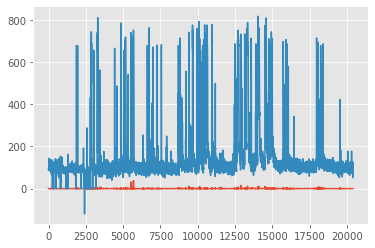

In [116]:
# plot dataset for visualiseation
plt.plot(xdataset)
plt.plot(ydataset)

The data set comtains a depth in mm and therefore of the order 100, rainfall intesnisty in mm/hr of the order 1 and a decimal time vaule. Therefore it is crucial that the data is standardsised as the significance of the inputs is crucial.

In [11]:
# normalize the dataset
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [12]:
# split into train and test sets this is a 90% train 10% test 
train_size  = int(len(dataset) * 0.90)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#count datapoints to check the split
print(len(train), len(test))

18351 2040


----------------- TRAINING DATA -----------------


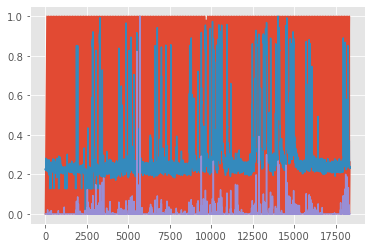

----------------- TEST DATA -----------------


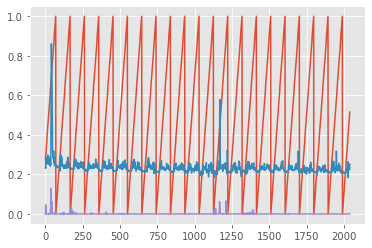

In [95]:
#plot the datasets for visualisation
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()


As this is a timeseries sequience problem we need to create a sliding window to determine what period of data we are going to take into account to make predictions. 

In [139]:
def sliding_windows(xdata, ydata, seq_length):
    x = []
    xtest =[]
    y = []

   # for i in range(len(xdata)-seq_length-1):
        #_x = xdata[i:(i+seq_length)]
        x.append(_x)
        

    #for i in range(len(ydata)-seq_length-1):
       # _y = ydata[i:(i+seq_length)]
        y.append(_y)
       

    return np.array(x), np.array(y) 

sc = MinMaxScaler()
xdata = sc.fit_transform(xdataset)
ydata = sc.fit_transform(ydataset)

#seq_length = 13657
x, y = sliding_windows(xdata, ydata, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Trying out pytorch to see if it can take the same kinds of inputs

In [141]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [142]:
num_epochs = 50
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainY)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward(retain_graph=True)
    
    optimizer.step()
    if epoch % 1 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/usr/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4511, 13657, 1])) that is different to the input size (torch.Size([4511, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (4511) must match the size of tensor b (13657) at non-singleton dimension 1

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## We can now reshape teh datasets to be used as tensors for the keras dequential LSTM model and train it based on the training dataset

In [9]:
trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

In [10]:
#Setup the LSTM
model = tf.keras.Sequential()
model.add(LSTM(3, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=100, verbose=1)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

I haven't had time to play around with hyperparameters. Batch size has been set to 100 in order to make full use of the GPU accelleration

## We can finally see what the predictiosn are doing for us, firstly in the training dataset, and then in the test dataset

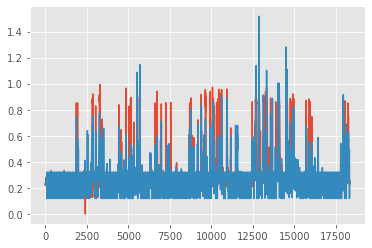

In [38]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot = trainPredict
 
# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot = testPredict
 
# plot baseline and predictions
plt.plot(trainY)
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
plt.show()

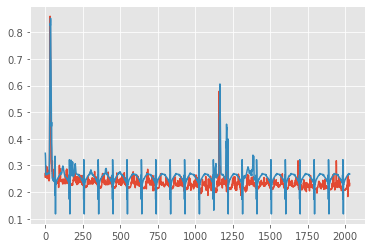

In [39]:
plt.plot(testY)
plt.plot(testPredictPlot)